In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
)
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, randint

In [2]:
SEED = 1926

In [3]:
DATA_TRAIN_PATH = "../data/trainset.csv"
data_train = pd.read_csv(DATA_TRAIN_PATH, delimiter=",")

In [4]:
cat_variables = ["country","gender","credit_card","active_member"]
dis_variables = ["products_number","tenure","age","credit_score"]
con_variables = ["balance","estimated_salary"]
num_variables = dis_variables + con_variables

target_variable = ["churn"]

In [5]:
X_train = data_train.drop(columns=target_variable)
y_train = data_train[target_variable]

### Variable preprocessing
- > numeric variables must be scaled or normalized
- > categorical variables must be encoded

In [6]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")
classifier = SVC()

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, num_variables),
        ("cat", encoder, cat_variables),
    ]
)

pipe = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", classifier),
            ]
        )

In [8]:
pipe.fit(X_train, y_train.values.flatten())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['products_number', 'tenure',
                                                   'age', 'credit_score',
                                                   'balance',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'gender',
                                                   'credit_card',
                                                   'active_member'])])),
                ('classifier', SVC())])

### Cross Validation

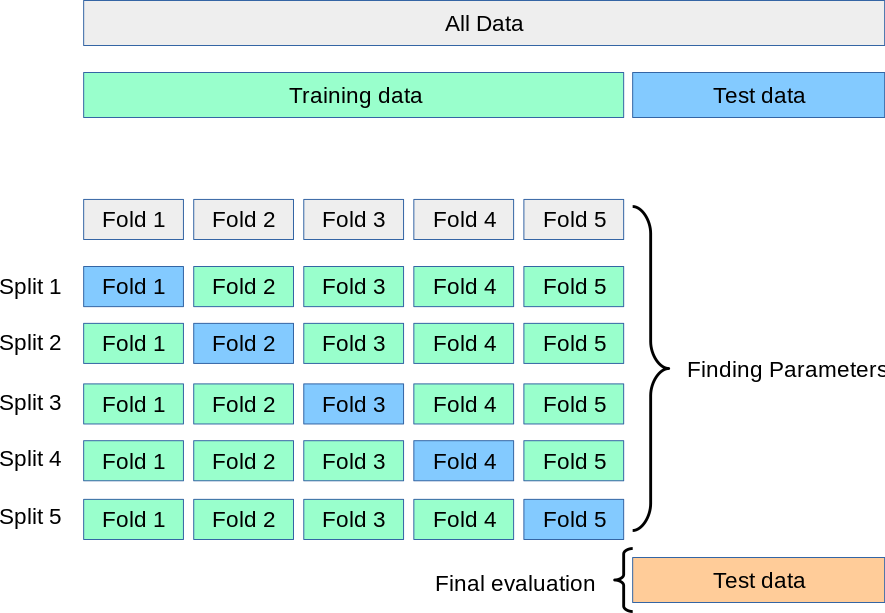

In [19]:
# Initialize StratifiedKFold cross-validator
cross_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Define hyperparameter search space
param_dist = {
    'classifier__C': uniform(0.1, 5),  # Regularization parameter
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel type
    'classifier__gamma': uniform(0.1, 1.0),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'classifier__degree': randint(1, 10),  # Degree of the polynomial kernel function (if kernel is 'poly')
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=cross_validator,
    refit = True,
    random_state=SEED,
)

# Perform random search
random_search.fit(X_train, y_train.values.flatten())

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'classifier__C': 3.8567425946842557, 'classifier__degree': 7, 'classifier__gamma': 0.3163073649404098, 'classifier__kernel': 'rbf'}
Best Score: 0.841625


In [20]:
DATA_TEST_PATH = "../data/testset.csv"
data_test = pd.read_csv(DATA_TEST_PATH, delimiter=",")
X_test = data_test.drop(columns=target_variable)
y_test = data_test[target_variable]

In [21]:
y_test_pred = random_search.best_estimator_.predict(X_test)

In [22]:
#accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
#print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_test)

Accuracy test: 0.856
